In [2]:
import folium
import pywraps2 as s2
import json

from IPython.display import Image, display


# Load geojson

In [3]:
with open('map.geosjon', 'r') as f:
    map_data = json.loads(f.read())

# Generate S2 Polygon

In [4]:
coords = map_data['features'][0]['geometry']['coordinates'][0]
vertices = [s2.S2LatLng.FromDegrees(v[1], v[0]) for v in coords[:-1]]
points = [v.ToPoint() for v in vertices]
loop = s2.S2Loop()
loop.Init(points)
loop.Normalize()
polygon = s2.S2Polygon(loop)

# Fill it with S2 cells

In [5]:
coverer = s2.S2RegionCoverer()
coverer.set_min_level(1)
coverer.set_max_level(30)
coverer.set_max_cells(1000)
s2_cells = coverer.GetCovering(polygon)

In [6]:
cell_tokens = [c.ToToken() for c in s2_cells]
cell_tokens[0:3]

['47d420b4', '47d420d', '47d4213']

In [7]:
len(s2_cells)

700

# Visualise

In [9]:
map_osm = folium.Map(location=[55, -1.86],zoom_start=5)

for cellid in s2_cells:
    cell = s2.S2Cell(cellid)
    vertices = []
    # As each cell has 4 vertices    
    for i in range(0, 4):
        vertex = cell.GetVertex(i)
        latlng = s2.S2LatLng(vertex)
        vertices.append([latlng.lng().degrees(),
                         latlng.lat().degrees()])
        
    gj = folium.GeoJson(
        {"type": "Polygon", "coordinates": [vertices]}, 
        style_function=lambda feature: {
            'weight': 1, 
            'fillColor':'#eea500'
        }
    )
    gj.add_children(folium.Popup(cellid.ToToken()))
    gj.add_to(map_osm)

gj2 = folium.GeoJson(
    { "type": "Polygon", "coordinates": [coords]}, 
    style_function=lambda feature: {
            'weight': 4, 
            'fillColor':'#ffffff'
    })
gj2.add_to(map_osm)
map_osm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


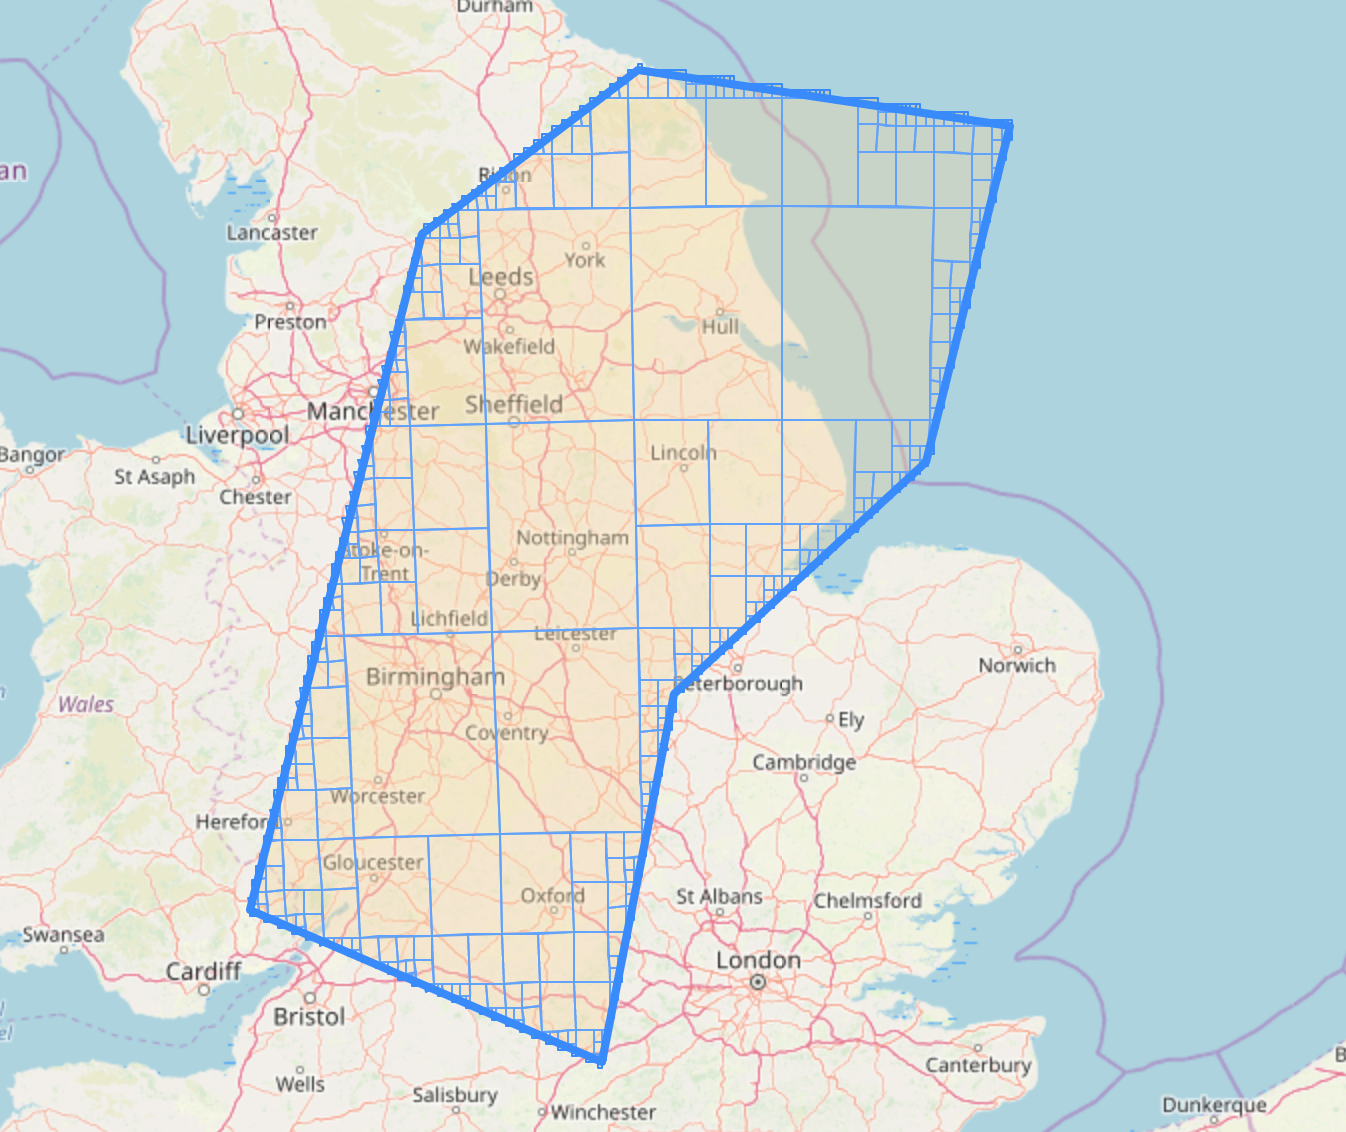

In [10]:
display(Image(filename='uk_test.png', embed=True))

# Checking if a point exists in Polygon

In [11]:
cell_union = s2.S2CellUnion(s2_cells)

In [12]:
pt = s2.S2LatLng.FromDegrees(52.01, -1.86).ToPoint()
cell_union.Contains(pt)

True

In [13]:
pt = s2.S2LatLng.FromDegrees(100, -1.86).ToPoint()
cell_union.Contains(pt)

False